In [1]:
import carla

import json
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from env.CarlaEnv import CarlaEnv
from utils.VideoRecorder import VideoRecorder

In [3]:
with open('./cfg/weather.json', 'r', encoding='utf8') as fff:
    weather_params = json.load(fff)
with open('./cfg/scenario.json', 'r', encoding='utf8') as fff:
    scenario_params = json.load(fff)

In [4]:
carla_env = CarlaEnv(
    weather_params=weather_params,
    scenario_params=scenario_params,
    selected_weather="L1",
    selected_scenario="jaywalk",
    carla_rpc_port=12321,
    carla_tm_port=18935,
    carla_timeout=8,
    perception_type="dvs_frame",
    num_cameras=5,
    rl_image_size=84,
    fov=60,
    max_fps=120,
    min_fps=45,
    max_episode_steps=1000,
    frame_skip=1,
)

now at: same_dir_veh
	 spawn vehicle: 1, at Location(x=232.895447, y=199.151566, z=0.100000)
	 spawn vehicle: 2, at Location(x=160.849258, y=199.145706, z=0.100000)
now at: oppo_dir_veh
	 spawn vehicle: 3, at Location(x=279.658844, y=195.155365, z=0.100000)
	 spawn vehicle: 4, at Location(x=150.638855, y=195.144882, z=0.100000)
	 spawn vehicle: 5, at Location(x=243.009018, y=195.152390, z=0.100000)
	 spawn vehicle: 6, at Location(x=195.785599, y=195.148560, z=0.100000)
	 spawn walker: 1, at Location(x=175.700531, y=203.446930, z=0.100000)
	 spawn walker: 2, at Location(x=268.196259, y=203.454437, z=0.100000)
	 spawn walker: 3, at Location(x=318.188019, y=203.458496, z=0.100000)
	 spawn walker: 4, at Location(x=262.528046, y=203.453979, z=0.100000)
	 spawn walker: 5, at Location(x=265.439362, y=203.454208, z=0.100000)
	 spawn walker: 6, at Location(x=182.851654, y=203.447510, z=0.100000)
	 spawn walker: 7, at Location(x=212.649094, y=203.449921, z=0.100000)
	 spawn walker: 8, at Locatio

In [5]:
throttle = []
brake = []
velocity = []

In [6]:
video = VideoRecorder("./video", fps=120)
video.init(True)

In [7]:
for i in range(200):

    obs, reward, done, info = carla_env.step([0, 0.7])

    video.record(obs)

    if False:
        # 可视化↓↓↓↓↓↓
        axs = init_fig()
        axs["rgb"].imshow(sync_mode.rgb_data["img"])
        axs["dvs"].imshow(sync_mode.dvs_data["img"])
        axs["vidar"].imshow(sync_mode.vidar_data["img"])
        axs["hybrid_rgb_dvs"].imshow(
            np.clip(
                sync_mode.rgb_data["img"].astype(np.float32) + sync_mode.dvs_data["img"].astype(np.float32),
                0,
                255
            ).astype(np.uint8)
        )
        axs["hybrid_dvs_vidar"].imshow(sync_mode.dvs_data["img"] + sync_mode.vidar_data["img"])
        axs["big_rgb"].imshow(sync_mode.rgb_data["img"])
        # 可视化↑↑↑↑↑↑ 
        display.clear_output(wait=True)
        plt.pause(1)


    print("frame: {}, rgb-frame: {}/{}, dvs-frame: {}/{}".format(
        carla_env.frame, carla_env.rgb_data["frame"], carla_env.rgb_data["timestamp"],
        carla_env.dvs_data["frame"], carla_env.dvs_data["timestamp"],
    ))

    throttle.append(carla_env.vehicle.get_control().throttle)
    brake.append(carla_env.vehicle.get_control().brake)
    velocity.append(carla_env.vehicle.get_velocity().x)


#     carla_env.vehicle.apply_control(
#         carla.VehicleControl(throttle=0.7, brake=0)
#     )


frame: 129, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [131, 131, 131, 131, 131]/[3.086832464672625, 3.086832464672625, 3.086832464672625, 3.086832464672625, 3.086832464672625]
frame: 133, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [135, 135, 135, 135, 135]/[3.120165799744427, 3.120165799744427, 3.120165799744427, 3.120165799744427, 3.120165799744427]
frame: 137, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [139, 139, 139, 139, 139]/[3.1534991348162293, 3.1534991348162293, 3.1534991348162293, 3.1534991348162293, 3.1534991348162293]
frame: 141, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [141, 141, 141, 141, 141]/[3.1701658023521304, 3.1701658023521304, 3.1701658023521304, 3.1701658023521304, 3.1701658023521304]
fr

frame: 172, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [172, 172, 172, 172, 172]/[3.428499149158597, 3.428499149158597, 3.428499149158597, 3.428499149158597, 3.428499149158597]
frame: 173, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [173, 173, 173, 173, 173]/[3.4368324829265475, 3.4368324829265475, 3.4368324829265475, 3.4368324829265475, 3.4368324829265475]
frame: 174, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [174, 174, 174, 174, 174]/[3.445165816694498, 3.445165816694498, 3.445165816694498, 3.445165816694498, 3.445165816694498]
frame: 175, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [175, 175, 175, 175, 175]/[3.4534991504624486, 3.4534991504624486, 3.4534991504624486, 3.4534991504624486, 3.4534991504624486]
fr

frame: 205, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [205, 205, 205, 205, 205]/[3.7034991635009646, 3.7034991635009646, 3.7034991635009646, 3.7034991635009646, 3.7034991635009646]
frame: 206, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [206, 206, 206, 206, 206]/[3.711832497268915, 3.711832497268915, 3.711832497268915, 3.711832497268915, 3.711832497268915]
frame: 207, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [207, 207, 207, 207, 207]/[3.7201658310368657, 3.7201658310368657, 3.7201658310368657, 3.7201658310368657, 3.7201658310368657]
frame: 208, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [208, 208, 208, 208, 208]/[3.7284991648048162, 3.7284991648048162, 3.7284991648048162, 3.7284991648048162, 3.728499164804816

frame: 238, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [238, 238, 238, 238, 238]/[3.9784991778433323, 3.9784991778433323, 3.9784991778433323, 3.9784991778433323, 3.9784991778433323]
frame: 239, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [239, 239, 239, 239, 239]/[3.986832511611283, 3.986832511611283, 3.986832511611283, 3.986832511611283, 3.986832511611283]
frame: 240, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [240, 240, 240, 240, 240]/[3.9951658453792334, 3.9951658453792334, 3.9951658453792334, 3.9951658453792334, 3.9951658453792334]
frame: 241, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [241, 241, 241, 241, 241]/[4.003499179147184, 4.003499179147184, 4.003499179147184, 4.003499179147184, 4.003499179147184]
fr

frame: 274, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [274, 274, 274, 274, 274]/[4.2784991934895515, 4.2784991934895515, 4.2784991934895515, 4.2784991934895515, 4.2784991934895515]
frame: 275, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [275, 275, 275, 275, 275]/[4.286832527257502, 4.286832527257502, 4.286832527257502, 4.286832527257502, 4.286832527257502]
frame: 276, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [276, 276, 276, 276, 276]/[4.295165861025453, 4.295165861025453, 4.295165861025453, 4.295165861025453, 4.295165861025453]
frame: 277, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [277, 277, 277, 277, 277]/[4.303499194793403, 4.303499194793403, 4.303499194793403, 4.303499194793403, 4.303499194793403]
frame: 

frame: 310, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [310, 310, 310, 310, 310]/[4.578499209135771, 4.578499209135771, 4.578499209135771, 4.578499209135771, 4.578499209135771]
frame: 311, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [311, 311, 311, 311, 311]/[4.586832542903721, 4.586832542903721, 4.586832542903721, 4.586832542903721, 4.586832542903721]
frame: 312, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [312, 312, 312, 312, 312]/[4.595165876671672, 4.595165876671672, 4.595165876671672, 4.595165876671672, 4.595165876671672]
frame: 313, rgb-frame: [0, 0, 93, 93, 94]/[0.0, 0.0, 2.7701657814905047, 2.7701657814905047, 2.7784991152584553], dvs-frame: [313, 313, 313, 313, 313]/[4.603499210439622, 4.603499210439622, 4.603499210439622, 4.603499210439622, 4.603499210439622]
frame: 314, 

In [8]:
video.save("test.mp4")

[swscaler @ 0x7555d80] Warning: data is not aligned! This can lead to a speed loss
[swscaler @ 0x6a63d80] Warning: data is not aligned! This can lead to a speed loss


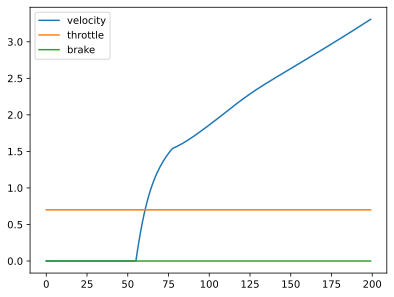

In [9]:
times = list(range(len(velocity)))

plt.plot(times, velocity, label="velocity")
plt.plot(times, throttle, label="throttle")
plt.plot(times, brake, label="brake")
plt.legend()